In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from  torch.autograd import Variable
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import random
import numpy as np
import copy
from collections import namedtuple, deque
import gym
import time as time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BUFFER_SIZE = int(1e6)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0.01
EPSILON = 0
EPSILON_DECAY = 1e-6
LEARNING_PERIOD = 20
UPDATE_FACTOR   = 10

env = gym.make('LunarLanderContinuous-v2')
seed = 101
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state = env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
threshold = env.spec.reward_threshold

print('Size of each action:', action_dim)
print('Each observes a state with length: {}', state_dim)
print('The state for the first agent looks like:', state[0])
print('Threshold: ', threshold)

Size of each action: 2
Each observes a state with length: {} 8
The state for the first agent looks like: -0.00046176912
Threshold:  200


C:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


#### DDPG Actor and Critic

In [3]:
def hidden_init(layer):
    limit = 1. / (layer.weight.data.size()[0] **0.5)
    return (-limit, limit)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.network = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, action_size),
        )
        self.param_reset()

    def param_reset(self):
        self.network[0].weight.data.uniform_(*hidden_init(self.network[0]))
        self.network[2].weight.data.uniform_(*hidden_init(self.network[2]))
        self.network[4].weight.data.uniform_(-0.003, 0.003)

    def forward(self, state):
        x = self.network[:4](state)
        x = F.relu(self.network[1](x))
        x = F.relu(self.network[3](x))
        return torch.tanh(self.network[4](x))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Sequential(
            nn.Linear(state_size, fcs1_units),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(fcs1_units + action_size, fc2_units),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(fc2_units, 1)
        self.param_reset()

    def param_reset(self):
        self.fcs1[0].weight.data.uniform_(*hidden_init(self.fcs1[0]))
        self.fc2[0].weight.data.uniform_(*hidden_init(self.fc2[0]))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = self.fcs1(state)
        x = torch.cat((xs, action), dim=1)
        x = self.fc2(x)
        return self.fc3(x)

In [4]:
class Agent():

    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.noise = OUNoise(action_size, random_seed)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

        # Make sure target is with the same weight as the source
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)

    def step(self, state, action, reward, next_state, done, timestep):   
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > BATCH_SIZE and timestep % LEARNING_PERIOD == 0:
            for _ in range(UPDATE_FACTOR):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()

        if add_noise:
            action += self.epsilon * self.noise.sample()

        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

        self.epsilon -= EPSILON_DECAY
        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

        
class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state
    
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [5]:
agent = Agent(state_size=state_dim, action_size=action_dim, random_seed=8)

def ddpg(n_episodes=2000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []

    time_start = time.time()

    timestep_after_last_save = 0
    total_timesteps = 0

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score_average = 0

        timestep = 0
        total_reward = 0

        done = False

        while True:
            action = agent.act(state)

            # Perform action
            next_state, reward, done, _ = env.step(action)
            done_bool = 0 if timestep + 1 == env._max_episode_steps else float(done)
            total_reward += reward

            agent.step(state, action, reward, next_state, done, timestep)
            state = next_state

            timestep += 1
            total_timesteps += 1
            timestep_after_last_save += 1

            if done:
                break

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        s = (int)(time.time() - time_start)

        if i_episode % print_every == 0 or (len(scores_deque) == 100 and np.mean(scores_deque) >= threshold):
            s = (int)(time.time() - time_start)
            print('Episode {} Score: {:.2f} Average Score: {:.2f}, Time: {:02}:{:02}:{:02} ***'\
                  .format(i_episode, total_reward, avg_score, s//3600, s%3600//60, s%60))


    return scores_array, avg_scores_array

scores, avg_scores = ddpg()

Episode 10 Score: -278.80 Average Score: -317.85, Time: 00:00:03 ***
Episode 20 Score: -384.45 Average Score: -514.60, Time: 00:00:07 ***
Episode 30 Score: -996.82 Average Score: -593.64, Time: 00:00:12 ***
Episode 40 Score: -2239.78 Average Score: -902.29, Time: 00:00:22 ***
Episode 50 Score: -2747.44 Average Score: -1278.45, Time: 00:00:33 ***
Episode 60 Score: -2558.40 Average Score: -1495.70, Time: 00:00:43 ***
Episode 70 Score: -285.38 Average Score: -1431.67, Time: 00:00:50 ***
Episode 80 Score: -277.52 Average Score: -1283.07, Time: 00:00:53 ***
Episode 90 Score: -174.57 Average Score: -1168.37, Time: 00:01:09 ***
Episode 100 Score: -1567.28 Average Score: -1062.75, Time: 00:01:33 ***
Episode 110 Score: -27.13 Average Score: -1044.58, Time: 00:01:58 ***
Episode 120 Score: -83.68 Average Score: -981.76, Time: 00:02:20 ***
Episode 130 Score: 33.87 Average Score: -908.14, Time: 00:02:47 ***
Episode 140 Score: -42.48 Average Score: -725.60, Time: 00:02:56 ***
Episode 150 Score: -58.

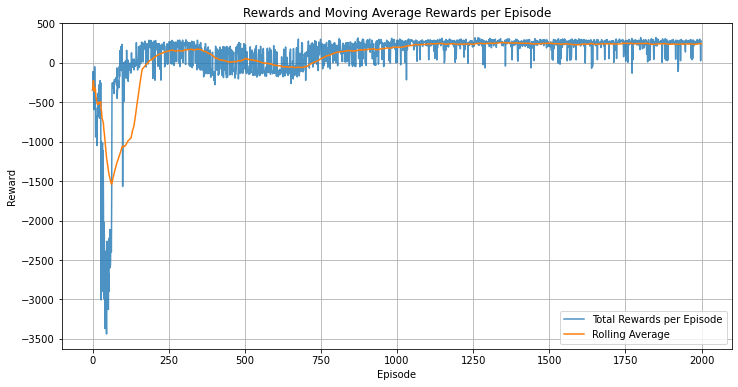

In [6]:

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(scores, alpha=0.8, label='Total Rewards per Episode')
ax.plot(avg_scores, label='Rolling Average')

ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Rewards and Moving Average Rewards per Episode')
ax.legend()
ax.grid(True)

plt.show()

In [7]:
def save(agent, filename, directory):
    os.makedirs(directory, exist_ok=True)
    
    checkpoint = {
        'actor_local_state_dict': agent.actor_local.state_dict(),
        'actor_target_state_dict': agent.actor_target.state_dict(),
        'critic_local_state_dict': agent.critic_local.state_dict(),
        'critic_target_state_dict': agent.critic_target.state_dict(),

        'actor_optimizer_state_dict': agent.actor_optimizer.state_dict(),
        'critic_optimizer_state_dict': agent.critic_optimizer.state_dict()
    }
    
    torch.save(checkpoint, os.path.join(directory, f'{filename}.pth'))

def load(agent, directory, filename):
    filepath = f'{directory}' + f'{filename}.pth'
    checkpoint = torch.load(filepath)
    
    agent.actor_local.load_state_dict(checkpoint['actor_local_state_dict'])
    agent.actor_target.load_state_dict(checkpoint['actor_target_state_dict'])
    agent.critic_local.load_state_dict(checkpoint['critic_local_state_dict'])
    agent.critic_target.load_state_dict(checkpoint['critic_target_state_dict'])
    
    # Optionally load the optimizer state
    agent.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
    agent.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])

# save(agent, 'LunarLander_DDPG', './Saved_files/DDPG')

In [ ]:
trained_agent = load(agent, './Saved_files/DDPG/', 'LunarLander_DDPG',) 

In [8]:
def play(env, agent, n_episodes):

    state = env.reset()
    scores_deque = deque(maxlen=100)

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()

        total_reward = 0
        time_start = time.time()
        timesteps =  0

        done = False

        while True:

            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            agent.step(state, action, reward, next_state, done, timesteps)
            state = next_state
            timesteps += 1

            if done:
                break

        delta = (int)(time.time() - time_start)

        scores_deque.append(total_reward)

        print('Episode {}\tAverage Score: {:.2f}, \t Timesteps: {} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), timesteps,\
                          delta//3600, delta%3600//60, delta%60))

In [ ]:
play(env=env, agent=agent, n_episodes=5)

In [ ]:
load(agent, './Saved_files/DDPG', '/LunarLander_DDPG')
play(env=env, agent=agent, n_episodes=10)

In [173]:
scores = np.array(scores)
scores.dump(open('./Saved_files/DDPG/DDPG_scores.npy', 'wb'))

avg_scores = np.array(avg_scores)
avg_scores.dump(open('./Saved_files/DDPG/DDPG_avg_scores.npy', 'wb'))



In [ ]:
env.close()